In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F #hay capas que no tienen parametros y se invocan como funciones

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

test_signs  train_signs  val_signs


In [4]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')

In [5]:
from plot_helpers import imshow

In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
class SIGNSDataset(Dataset):
  def __init__(self, base_dir, split="train", transform=None):
    path = os.path.join(base_dir, "{}_signs".format(split))
    files = os.listdir(path)

    self.filenames = [os.path.join(path, f) for f in files if f.endswith(".jpg")]

    self.targets = [int(f[0]) for f in files]

    self.transform = transform
  
  def __len__(self):
    return len(self.filenames)


  def __getitem__(self, idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)

    return image, self.targets[idx]
    

  



In [7]:
signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train")

In [8]:
len(signs)

864

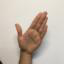

In [ ]:
signs[0][0]

In [9]:
import torchvision.transforms as transforms

trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transforms.ToTensor())

In [10]:
dataloader = DataLoader(trainset, batch_size=32)  #data loader entrega por batches el dataset a la red neuronal

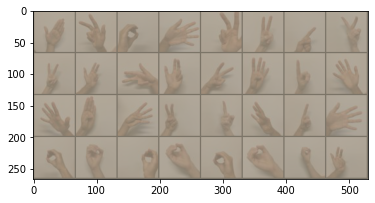

tensor([5, 3, 0, 5, 3, 2, 1, 2, 2, 3, 3, 3, 2, 4, 1, 5, 5, 4, 4, 2, 1, 4, 1, 5,
        0, 0, 0, 0, 0, 0, 0, 3])


In [11]:
from torchvision.utils import make_grid
for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break


In [12]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__() #inizializacion
    # 3 capas convolucionales y 2 capas fully connected
    self.num_channels = num_channels
    
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1) #canales de entradqa, canales de salida, kernel size
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    #en las capas sin parametros, maxpool: divide el tamaño de la imagen entre 2
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4) # entrada y salida            linear o fullyConnected
    self.fc2 = nn.Linear(self.num_channels*4, 6) # 6 es la salida final de la red
    
  def forward(self,x):
      #Empieza 3x64x64
      x = self.conv1(x) # num_channels x 64 x 64
      x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
      x = self.conv2(x) # num_channels*2 x 32 x32
      x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 16 x 16
      x = self.conv3(x) # num_channels*4 x16x16
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8

      #flatten
      x = x.view(-1, self.num_channels*4*8*8) #-1 flatten, size

      #fc
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      #log_softmax

      x = F.log_softmax(x, dim=1)

      return x             

In [13]:
#entrenamiento

import torch.optim as optim
device = torch.device('cuda')


In [14]:
device

device(type='cuda')

In [16]:
net = Net(32).to(device) #el parametro es el numero de canales

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)

In [17]:
#suma de valores y cantidad o tamaño de valores
class RunningMetric():
  def __init__(self):
      self.S = 0
      self.N = 0
  def update(self, val, size):
    self.S+=val
    self.N+= size

  def __call__(self):
    return self.S/float(self.N)

In [18]:
num_epoch = 100 #pasadas dataset

In [20]:
#loop de entrenamiento

for epoch in range(num_epoch):
  print('Epoch {} / {} '.format(epoch+1, num_epoch))
  print('-'*10)
  running_loss = RunningMetric() #perdida
  running_acc = RunningMetric() #precision

  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad() #reset
    outputs = net(inputs)
    _, preds = torch.max(outputs,1)
    loss = loss_fn(outputs, targets)

    loss.backward() # gradientes calculados automaticamente
    optimizer.step() #Actualiza parametros

    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size, batch_size)

    running_acc.update(torch.sum(preds == targets).float(), batch_size)
  print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(), running_acc()))



Epoch 1 / 100 
----------
Loss: 1.7935 Acc: 0.1667 
Epoch 2 / 100 
----------
Loss: 1.7916 Acc: 0.1736 
Epoch 3 / 100 
----------
Loss: 1.7905 Acc: 0.1725 
Epoch 4 / 100 
----------
Loss: 1.7896 Acc: 0.1725 
Epoch 5 / 100 
----------
Loss: 1.7888 Acc: 0.1725 
Epoch 6 / 100 
----------
Loss: 1.7880 Acc: 0.1725 
Epoch 7 / 100 
----------
Loss: 1.7871 Acc: 0.1725 
Epoch 8 / 100 
----------
Loss: 1.7861 Acc: 0.1829 
Epoch 9 / 100 
----------
Loss: 1.7850 Acc: 0.2465 
Epoch 10 / 100 
----------
Loss: 1.7838 Acc: 0.2824 
Epoch 11 / 100 
----------
Loss: 1.7824 Acc: 0.2998 
Epoch 12 / 100 
----------
Loss: 1.7808 Acc: 0.3079 
Epoch 13 / 100 
----------
Loss: 1.7789 Acc: 0.3113 
Epoch 14 / 100 
----------
Loss: 1.7765 Acc: 0.3194 
Epoch 15 / 100 
----------
Loss: 1.7736 Acc: 0.3368 
Epoch 16 / 100 
----------
Loss: 1.7700 Acc: 0.3565 
Epoch 17 / 100 
----------
Loss: 1.7656 Acc: 0.3634 
Epoch 18 / 100 
----------
Loss: 1.7600 Acc: 0.3588 
Epoch 19 / 100 
----------
Loss: 1.7528 Acc: 0.3461 
Ep